<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Re-analysis-of-Poon-et-al-data-on-within-human-influenza-diversity" data-toc-modified-id="Re-analysis-of-Poon-et-al-data-on-within-human-influenza-diversity-1">Re-analysis of Poon et al data on within-human influenza diversity</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules" data-toc-modified-id="Import-Python-modules-1.1.1">Import Python modules</a></span></li><li><span><a href="#Define/create-directories-for-results" data-toc-modified-id="Define/create-directories-for-results-1.1.2">Define/create directories for results</a></span></li></ul></li><li><span><a href="#Download-the-sequencing-data" data-toc-modified-id="Download-the-sequencing-data-1.2">Download the sequencing data</a></span></li><li><span><a href="#Get-samples-and-FASTQ-files" data-toc-modified-id="Get-samples-and-FASTQ-files-1.3">Get samples and FASTQ files</a></span></li><li><span><a href="#Get-read-pairing-stats-across-samples" data-toc-modified-id="Get-read-pairing-stats-across-samples-1.4">Get read pairing stats across samples</a></span></li><li><span><a href="#Summarize-read-pair-sharing-among-samples" data-toc-modified-id="Summarize-read-pair-sharing-among-samples-1.5">Summarize read pair sharing among samples</a></span></li></ul></li></ul></div>

# Re-analysis of Poon et al data on within-human influenza diversity
This notebook re-analyzes the results of [Poon et al (2016)](https://www.nature.com/articles/ng.3479).

The notebook is by [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).
The goal is to independently confirm key findings from Katherine Xue's analysis.
The reason for independently repeating Katherine's analysis is to provide increased confidence in the results.

## Set up for analysis
First, we set up the notebook for the analysis.

### Import Python modules
We import the Python modules / packages used in the analysis.

Note that these include the [synapseclient](http://docs.synapse.org/python/) package, which you will probably need to install by `pip`. 
This is a package that [Synapse](https://www.synapse.org/) provides to download data from their site.

In [1]:
import os
import re
import subprocess
import csv
import glob
import time
import collections

# non-standard packages that you may need to install
from IPython.display import display, Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import numpy
import pandas
import HTSeq
import synapseclient
import synapseutils
import pympler.asizeof

### Define/create directories for results
All results go in the `./results/` directory and sensibly named subdirectories therein.

In [2]:
resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)

## Download the sequencing data
The original [Poon et al (2016)](https://www.nature.com/articles/ng.3479) study put sequencing data on the Sequence Read Archive.
However, we were told by people who had re-analyzed that data (e.g., Ashley Sobel Leonard) that the preferred way to access the data was to use the data that the authors of [Poon et al (2016)](https://www.nature.com/articles/ng.3479) posted on [Synapse](https://www.synapse.org/) under [ID syn8033988](https://www.synapse.org/#!Synapse:syn8033988), as described in [Leonard et al (2017)](http://jvi.asm.org/content/91/14/e00171-17.long).

A recommended way to download such data is via [synapseclient](http://docs.synapse.org/python/). 
Here we do that.
Note that [Synapse](https://www.synapse.org/) requires a password to download, and their terms of use appear to require keeping that password secret. 
So in the code below, I have entered my username and password.
Then after running the cell, I have changed my password to just show up as *PASSWORD* which is **not** my actual password.
So in order for you to re-run this notebook and have the download step work, you need to sign up to create your own account and enter your username and password. 

Note that this cell only downloads the data if it doesn't already exist.

In [3]:
# download Poon data here
datadir = os.path.join(resultsdir, 'Poon_data')

# Poon data unzips into here
rawdatadir = os.path.join(datadir, 'rawfiles')

# File listing samples will be here
samplefile = os.path.join(datadir, 'bacid_blindednumber_virusname_filename.txt')

if os.path.isfile(samplefile):
    # If sample file exists, assume all data already present
    print("Data already downloaded")
    
else:
    # We need to download data
    # This is where you need to enter *your* Synapse user name and password
    username = 'jbloom'
    password = 'PASSWORD'

    syn_client = synapseclient.Synapse()
    syn_client.login(username, password, silent=True)
    print("Starting Synapse download...")
    syn_files = synapseutils.syncFromSynapse(syn_client, 'syn8033988', path=datadir)
    print("Synapse download complete.")
    syn_client.logout()
    assert os.path.isfile(samplefile), "didn't download {0}".format(samplefile)
    
    tarfile = os.path.join(datadir, 'hongkong_rawdata.tar.gz')
    print("Unpacking {0}...".format(tarfile))
    subprocess.check_call(['tar', 'xzvf', tarfile, '-C', datadir])
    print("Completed unpacking.")


Data already downloaded


## Get samples and FASTQ files
The text file listing the samples (downloaded with the name described by *samplefile* above) gives information on each sample.
For instance, here is the first line of that file:

In [4]:
with open(samplefile) as f:
    print("{0}".format(f.readline().strip()))

36803,NIGSP_CEIRS_SJC002_MPA_00001,Influenza A virus (A/Hong Kong/H090-662-V10/2009(H3N2)),clc_trimmed_giv_MPA_36803_final.fastq.gz


According to the README file that is provided in the data download, the first number (*36803* in the line above) is the sample number.
The third comma-separated entry gives the strain number, and in this number the *H090-662-V10* gives the household and patient identifier used in the [Poon et al (2016)](https://www.nature.com/articles/ng.3479) paper
For instance, see the patient identifiers used in the x-axis of [Figure 2 of Poon et al (2016)](https://www.nature.com/articles/ng.3479/figures/2)--it is apparent that *H090* is a household identifier, and *662-V10* is a patient identifier.
The final comma-separated entry gives the name of the FASTQ file with the actual sequencing data for this sample number.
Most patients have two sample numbers corresponding to the two sequencing replicates.

We will "name" each sample as a concatenation of the sample number and patient identifier. 
For instance, the line above would correspond to the sample called *36803-662-V10*.

Below we get all of these sample names and their corresponding FASTQ files.
We then check that all FASTQ files exist (e.g., were properly downloaded above) and also that all downloaded FASTQ files are accounted for by the expected sample names.

In [5]:
samples = {} # keyed by sample name, values FASTQ file

strain_match = re.compile('^Influenza A virus \(A/Hong Kong/'
                          'H\d{3}\-(?P<patient_id>\d{3}\-V[_\d]{2,3})'
                          '/2009\((H1N1|H3N2|mixed)\)\)$')

with open(samplefile) as fin:
    for [num, _, strain, fastqfile] in csv.reader(fin):
        m = strain_match.search(strain)
        assert m, "Could not match strain name: {0}".format(strain)
        s = '{0}-{1}'.format(num, m.group('patient_id'))
        samples[s] = os.path.join(rawdatadir, fastqfile)
        assert os.path.isfile(samples[s]), "No file {0}".format(samples[s])
print("Found all {0} expected FASTQ files in {1}".format(len(samples), rawdatadir))  

# check no extra FASTQ files exist in download directory
assert set(map(os.path.normpath, glob.glob(os.path.join(rawdatadir, '*.fastq.gz')))) == \
        set(map(os.path.normpath, samples.values())), "Found extra FASTQ files"

Found all 216 expected FASTQ files in ./results/Poon_data/rawfiles


## Get read pairing stats across samples
We will now iterate through all the FASTQ files parsing out the read headers and looking where we find the mate pair for each read.
We use [HTSeq FASTQ reader](https://htseq.readthedocs.io/en/release_0.9.1/sequences.html#fastqreader) to read the FASTQ files.

The reads have headers that match the Illumina header format used in the pipeline from 1.4 up through 1.7 (see [the description of the header format specification here](https://en.wikipedia.org/wiki/FASTQ_format#Illumina_sequence_identifiers)).
For instance, the following header:

    SOLEXA4_0078:7:1101:10000:4338#CGATGT/2
    
indicates a read from instrument *SOLEXA4_0078*, flow cell 7, tile number 1101, and cluster coordinate 10000, 4338.
The *#CGATGT* indicates the index, and the */2* indicates that this was read 2.
For each read specification, there should be exactly one read 1 and one read 2 read, although if they were mapped independently and unmapped reads discarded, then one might be absent in some cases.
Importantly, when both reads are present they should **always** be for the same sample, since they correspond to the same physical molecule of DNA.
For istance, the read 1 that pairs with the read 2 above would have a header:

    SOLEXA4_0078:7:1101:10000:4338#CGATGT/1
    
Below for each read we parse out the read pair identifier (everything preceding the */1* or */2*) and whether it is read 1 or read 2.

We want to do this in a CPU efficient manner, so we hash the reads by read pair identifier in memory.
Specifically, we store each read pair identifier we encounter in a Python *dict* that indicates the sample and read (1 or 2).
We use a *dict* because the look-up time is fast--however, we are storing a lot in memory.
Therefore, this needs to be run on a large-memory node.
We use [pympler.asizeof](https://pythonhosted.org/Pympler/asizeof.html) to periodically print the size of this dictionary in memory to make sure it isn't getting too large.

The result of all of this is two CSV files: one gives the matrix of how often samples have read pairs split across them, and the second gives the number of unpaired reads for each sample.
If these CSV files already exist, then we do not re-run all the other code.

In [6]:
# create directory to save results
readstatsdir = os.path.join(resultsdir, 'read_stats')
if not os.path.isdir(readstatsdir):
    os.mkdir(readstatsdir)

# files that will store results
pairs_file = os.path.join(readstatsdir, 'shared_readpairs.csv')
unpaired_file = os.path.join(readstatsdir, 'unpaired_reads.csv')

if all(map(os.path.isfile, [pairs_file, unpaired_file])):
    # output CSV files already exist
    print("Output files from read-pair analyses already exist.")
    
else:

    head_match = re.compile(
            '(?P<readpair_id>^SOLEXA\d_\d{4}:' # machine
            '\d+:' # flow cell number
            '\d+:' # tile
            '\d+:\d+' # cluster coordinate
            '#[NACGT]{6})' # index
            '/(?P<r1or2>[12])$' # read 1 or 2?
            )

    start_time = time.time()
    read_dict = {} # store readpair IDs
    paired_set = set([]) # track whether readpair IDs have been paired
    pairs = collections.defaultdict(int) # count pairs spanning each pair of samples

    print("Now processing all read pairs...")

    for (isample, (sample, fastqfile)) in enumerate(sorted(samples.items())):
    
        if (isample + 1) % 10 == 0:
            print("Parsing file {0} of {1}. " 
                  "Time elapsed is {2:.1f} min, "
                  "read_dict is {3:.2f} GB, "
                  "paired_set is {4:.2f} GB.".format(
                      isample + 1, 
                      len(samples),
                      (time.time() - start_time) / 60,
                      pympler.asizeof.asizeof(read_dict) / 1.e9,
                      pympler.asizeof.asizeof(read_dict) / 1.e9,
                      ))
    
        for (read, head, q, qtype) in HTSeq.FastqReader(fastqfile, raw_iterator=True):
            m = head_match.match(head)
            assert m, "Could not match header {0}".format(head)
            readpair_id = m.group('readpair_id')
            assert readpair_id not in paired_set, "already paired {0}".format(readpair_id)
            r1or2 = m.group('r1or2')
        
            if readpair_id in read_dict: 
                (other_sample, other_r1or2) = read_dict[readpair_id]
                assert r1or2 != other_r1or2, "2 reads same sense, {0}".format(readpair_id)
                pairs[(other_sample, sample)] += 1
                paired_set.add(readpair_id) # record we have paired this read
                del read_dict[readpair_id] 
            else:
                # first occurrence of this readpair ID
                read_dict[readpair_id] = (sample, r1or2)
            
    print("Finished processing read pairs.")
    
    # make pairs "symmetric" as we only stored with alphabeticized index tuples
    for s1 in sorted(samples):
        for s2 in sorted(samples):
            pairs[(s2, s1)] = pairs[(s1, s2)]
        pairs[(s1, s1)] *= 2 # double count diagonal.
    # now write pairs to CSV file as matrix
    pandas.Series(pairs).unstack().to_csv(pairs_file)
    
    # now get number of unpaired reads per sample, write to CSV file
    unpaired = collections.defaultdict(int)
    for (sample, _) in read_dict.values():
        unpaired[sample] += 1
    pandas.Series(unpaired).to_csv(unpaired_file)
    
print("\nThe number of read pairs shared between samples is in {0}".format(pairs_file))
print("The number of unpaired reads per sample is in {0}".format(unpaired_file))

Output files from read-pair analyses already exist.

The number of read pairs shared between samples is in ./results/read_stats/shared_readpairs.csv
The number of unpaired reads per sample is in ./results/read_stats/unpaired_reads.csv


The results are now in the two CSV files whose names are printed by the cell immediately above.

The file with the read pairs is a matrix with values giving the number of read pairs shared between samples. 
The matrix is symmetric and so each across-sample read pair is counted once in the upper diagonal, and once in the lower diagonal.
The diagonal gives **twice** the number of shared read pairs within a sample.

The file with the unpaired reads simply gives the number of reads for each sample that have no pair in any of the other files.

## Summarize read pair sharing among samples
First we read the two CSV files created above into data frames, making sure that the indices and columns (sample names) are alphabetically sorted.

In [7]:
pairs_df = pandas.read_csv(pairs_file, index_col=0).sort_index().sort_index(axis=1)

unpaired_df = pandas.read_csv(unpaired_file, index_col=0, names=['nreads']).sort_index()

assert all(pairs_df.index == unpaired_df.index), "not same samples in both dataframes"
assert all(pairs_df.index == pairs_df.columns), "pairs_df doesn't have same rows and columns"

For each sample, we next categorize each individual read as:
  1. Paired with another read in that sample.
  2. Paired with a read in another sample (these reads should **never** exist for properly processed paired-end Illumina data).
  3. Not paired with any read in any sample.
  
We then plot the number of reads of each type for each sample:

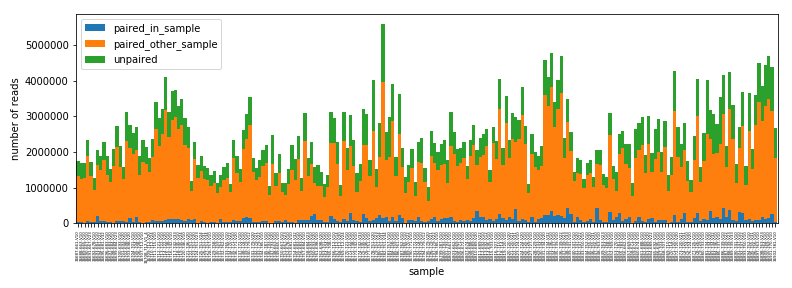

In [8]:
plotsdir = os.path.join(resultsdir, 'plots')
if not os.path.isdir(plotsdir):
    os.mkdir(plotsdir)

# reads paired in sample is diagonal of pairs_df: https://stackoverflow.com/a/37310433
readstats = pandas.Series(numpy.diag(pairs_df), index=pairs_df.index).to_frame('paired_in_sample')

# reads paired in other sample is total reads not paired in sample 
readstats['paired_other_sample'] = pairs_df.sum(axis=1) - readstats['paired_in_sample']

readstats['unpaired'] = unpaired_df['nreads']

ax = (readstats[['paired_in_sample', 'paired_other_sample', 'unpaired']]
     .plot.bar(stacked=True, width=1, figsize=(11, 4))
     )
ax.set_ylabel("number of reads")
ax.set_xlabel("sample")
ax.tick_params(axis='x', which='major', labelsize=4)
plotname = os.path.join(plotsdir, 'read_pairing_counts.png')
plt.tight_layout()
plt.savefig(plotname)
display(Image(plotname))
plt.close()

It is clear from the above plot that although most reads do have pairs somewhere in the data set, they are usually **not** in the same sample.
This is unexpected, as read pairs correspond to sequencing of the same molecule of DNA, and so should always be for the same sample.

Next, we cluster samples by their sharing of read pairs and plot the results.
We do the clustering and visualization using [seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html):

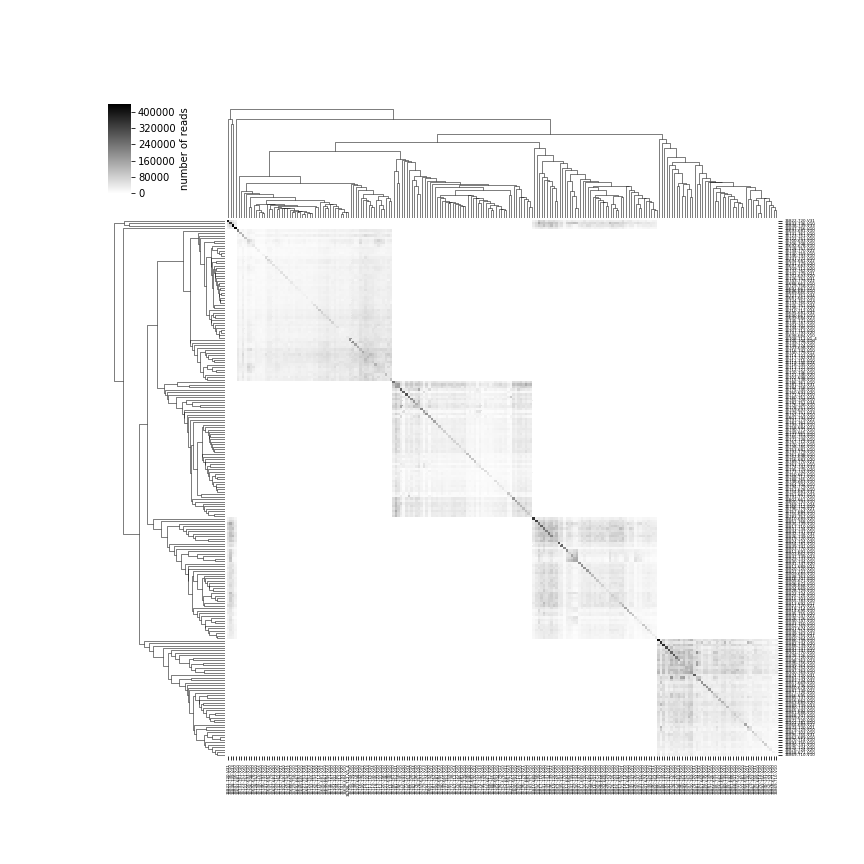

In [9]:
ax = seaborn.clustermap(pairs_df, 
                        cmap='binary',
                        cbar_kws={'label':'number of reads'},
                        xticklabels=1,
                        yticklabels=1,
                        figsize=(12, 12))
ax.ax_heatmap.tick_params(axis='both', which='major', labelsize=4)
plotname = os.path.join(plotsdir, 'sample_clustering.png')
plt.tight_layout()
plt.savefig(plotname)
plt.close()
display(Image(plotname))

This plot shows that read pairs are shared across several groups of samples.
Therefore, this provides a technical explanation for the high sharing of viral genetic diversity reported by [Poon et al (2016)](https://www.nature.com/articles/ng.3479).
The key point is that if reads were paired exclusively within samples as is expected, **all** the points in the above heatmap should be on the diagonal.